# Text Generation with Transformers

In this notebook we use the components developed in `modelling.transformer` to train a transformer decoder for our text generation task. We will compare the performance of this model with that established by our RNN baseline.

## Imports

The bulk of the code required to setup, train and generate new text from the model, is contained within `modelling.transformer` (check the source code for the details). We import this module together with others that serve the training data and manage model persistence.

In [10]:
import warnings

from torch import device
from torch.utils.data import DataLoader

from modelling import data as data
from modelling import transformer as tfr
from modelling import utils as utils

warnings.filterwarnings("ignore")

## Model and Training Parameters

Configure hyper-parameters for the model and the training routine.

In [11]:
MODEL_NAME = "decoder_next_word_gen"

SIZE_EMBED = 256

MAX_EPOCHS = 30
BATCH_SIZE = 64
SEQ_LEN = 100
MIN_WORD_FREQ = 2
MAX_LEARNING_RATE = 0.001
WARMUP_EPOCHS = 2
GRADIENT_CLIP = 5

DEVICE = device("cpu")

Note that we have explicitly chosen to train this model on the CPU as the MPS backend (for Apple silicon) doesn't (yet) have support for all the calculations required by multi-head attention. Consequently, it has to fall back on the CPU for some calculations and this constant back-and-forth results in significantly longer training times.

## Setup Training Data

In [12]:
datasets = data.make_sequence_datasets(seq_len=SEQ_LEN, min_freq=MIN_WORD_FREQ)

train_dl = DataLoader(
    datasets.train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

val_dl = DataLoader(
    datasets.val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

## Instantiate Model

In [4]:
model = tfr.NextWordPredictionTransformer(datasets.tokenizer.vocab_size, SIZE_EMBED)
model

NextWordPredictionTransformer(
  (_position_encoder): PositionalEncoding(
    (_dropout): Dropout(p=0.1, inplace=False)
  )
  (_embedding): Embedding(133046, 256)
  (_decoder): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=Fa

Let's count how many parameters this model has.

In [5]:
print(f"{utils.count_params(model):,}")

406,306


If we compare this model with the RNN model, then it is easy to see that this one is significantly more complex with many more layers (and thus parameters). We start with the same embedding layer albeit combined with a positional encoding, that is then fed into a transformer decoder layer comprised of two multi-head attention blocks, two linear (dense) feed-forward layers and three sets of layer normalisation and dropout.

## Train

As well as having a far more complex architecture, transformer based models are also trickier to train successfully. In particular, the vast number of parameters can lead to gradients that can grow very large in the early stages of training, thus preventing convergence.

We handle this using a learning rate schedule that starts close to zero and slowly ramps-up, before falling again as we reach the end of the desired number of epochs. We also clip the gradients - see the source code for the full details.

In [6]:
train_losses, val_losses, cp = tfr.train(
    model,
    train_dl,
    val_dl,
    MAX_EPOCHS,
    MAX_LEARNING_RATE,
    WARMUP_EPOCHS,
    GRADIENT_CLIP,
    device=DEVICE,
)
utils.save_model(model, name=MODEL_NAME, loss=min(val_losses.values()))

number of warmup steps: 1332 / 19980


epoch 9 training loss = 4.4514 (LR = 0.00079389): 100%|██████████| 666/666 [1:10:59<00:00,  6.40s/it]



best model:
|-- epoch: 8
|-- loss: 5.0299


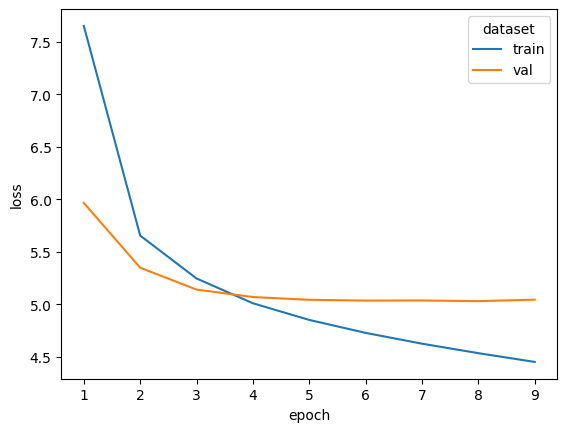

In [7]:
utils.plot_train_losses(train_losses, val_losses)

## Generate Text with Model

Start by loading a model and instantiating a tokenizer that can also map from tokens back to text. The `load_model` function will load the best performing model that has been persisted on the local filesystem.

In [13]:
best_model: tfr.NextWordPredictionTransformer = utils.load_model(MODEL_NAME)

loading .models/decoder_next_word_gen/trained@2023-07-22T17:21:16;loss=4_9277.pt


Then set a prompt.

In [14]:
prompt = "I love horror, but"

### Greedy Decoding Strategy

Pass a prompt to the model and use a greedy decoding strategy to generate new text.Now pass a prompt to the model and get it to generate the text that comes after.

In [15]:
text = tfr.generate(
    best_model, prompt, datasets.tokenizer, "greedy", SEQ_LEN, temperature=1.0,
)
print(text)

==> I LOVE HORROR, BUT I dont think this movie is a waste of time. I dont think it is a
good movie. I dont think it is a good movie. I dont think it is a good movie. I dont
think it is a good movie. I dont think it is a good movie. I dont think it is a good
movie. I dont think it is a good movie. I dont think it is a good movie. I dont think it
is a good movie. I dont think it is a good movie...


### Top-k Decoding Strategy

Pass a prompt to the model and use a top-k decoding strategy to generate new text (with k=5).

In [16]:
text = tfr.generate(
    best_model, prompt, datasets.tokenizer, "topk", SEQ_LEN, temperature=1.0, k=5
)
print(text)

==> I LOVE HORROR, BUT this is one of those movies where the characters are all over the
top publicist. The acting is so bad its not even funny. The acting was horrible. The only
reason I saw that the movie was so horrible I was in a way to see it. The plot was so
lame. It was just a bunch of people that dont get to know if the actors in a movie that
you should see this. Its a waste of your time. I hope that this movie will make you laugh
and watch it...


### Sampling Decoding Strategy

Pass a prompt to the model and use a sampling decoding strategy to generate new text.

In [17]:
text = tfr.generate(
    best_model, prompt, datasets.tokenizer, "sample", SEQ_LEN, temperature=1.0
)
print(text)

==> I LOVE HORROR, BUT to its poor self gratifying mockery. <unk> definitely deserving of
3. 1 a while from below summary the acting is poor the direction and story lines does not
matter how much. As a result of this kind a film where dull meaningless sht. 110. Pisses
children away to me off. Isnt it was the suspense. The plot was fairly elementary and
occasionally threatening scenes. I do hope this film will as for people who know more
about the cause of thirst for blood violence violence with considerable power to
eroticism involved with...


### Benchmark

Compare all output with that from an untrained model.And compare this output with that from an untrained model.

In [18]:
untrained_model = tfr.NextWordPredictionTransformer(
    datasets.tokenizer.vocab_size, SIZE_EMBED
)
text = tfr.generate(
    untrained_model, prompt, datasets.tokenizer, "greedy", SEQ_LEN, temperature=1.0
)
print(text)

==> I LOVE HORROR, BUT swiping swiping swiping forgivable forgivable forgivable
forgivable snoops sibrel snoops honky honky forgivable forgivable forgivable forgivable
argentine argentine argentine sibrel sibrel luxuries luxuries ferdos beatons ferdos
sibrel sibrel sibrel sibrel sibrel sibrel sibrel sibrel ferdos sibrel ferdos sibrel
ferdos argentine ferdos meyerlings meyerlings yamaguchi yamaguchi yamaguchi yamaguchi
yamaguchi beckys beckys goading goading goading goading goading goading goading goading
responds generally generally yamaguchi scarface argentine argentine argentine bails bails
f14s willys bolls bolls bolls bolls removed removed removed anil resolved resolved
resolved ninja terminology sincere brutus merritt merritt merritt con tesich ninja ferdos
ferdos ferdos ferdos ferdos ferdos ferdos dunsts dunsts...
